## Santander Customer Satisfaction Challenge

### Problema binário

Nesta competição, você trabalhará com centenas de features anônimas para prever se um cliente está satisfeito (0) ou insatisfeito (1) com sua experiência bancária.

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from matplotlib import pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score

Load dos datasets de treino e teste.

Dataset desbalanceado:

TARGET

0: 73012

1: 3008

In [2]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

print(train.shape)
print(test.shape)

(76020, 371)
(75818, 370)


Remoção de colunas com valores constantes (std = 0). Para valores iguais na coluna, desvio padrao é 0.

In [3]:
remove = []
for col in train.columns:
    if train[col].std() == 0:
        remove.append(col)
#axis: 1 para olhar coluna e 0 para linha
#inplace: faz o replace na propria instancia
train.drop(remove, axis=1, inplace=True)
test.drop(remove, axis=1, inplace=True)

print(train.shape)
print(test.shape)

(76020, 337)
(75818, 336)


Remoção de colunas duplicadas

In [4]:
remove = []
cols = train.columns
for i in range(len(cols)-1):
    v = train[cols[i]].values
    for j in range(i+1,len(cols)):
        if np.array_equal(v,train[cols[j]].values):
            remove.append(cols[j])

train.drop(remove, axis=1, inplace=True)
test.drop(remove, axis=1, inplace=True)

print(train.shape)
print(test.shape)

(76020, 308)
(75818, 307)


Split dos datasets e remoção dos atributos ID e TARGET

In [5]:
test_id = test.ID
x_test = test.drop(["ID"],axis=1)

x_train = train.drop(["TARGET","ID"],axis=1)
y_train = train["TARGET"]
target = train.TARGET.values

Normaliza cada caracteristica a norma da unidade (comprimento do vetor)

In [6]:
features = train.columns[1:-1]

classes = np.sort(np.unique(y_train))
labels = ["Clientes satisfeitos", "Clientes insatisfeitos"]

x_train_normalized = normalize(train[features], axis=0)
x_test_normalized = normalize(x_test[features], axis=0)

print(x_train_normalized.shape)
print(x_test_normalized.shape)

(76020, 306)
(75818, 306)


Execução do PCA (Principal component analysis)

In [7]:
pca = PCA(n_components=3)
x_train_projected = pca.fit_transform(x_train_normalized)
x_test_projected = pca.fit_transform(x_test_normalized)

x_train.insert(1, 'PCAOne', x_train_projected[:, 0])
x_train.insert(1, 'PCATwo', x_train_projected[:, 1])
x_train.insert(1, 'PCAThree', x_train_projected[:, 2])

x_test.insert(1, 'PCAOne', x_test_projected[:, 0])
x_test.insert(1, 'PCATwo', x_test_projected[:, 1])
x_test.insert(1, 'PCAThree', x_test_projected[:, 2])

Visualizar

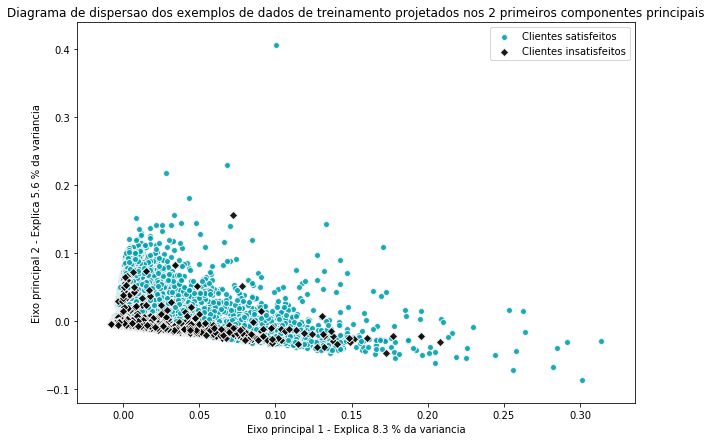

(76020, 309)
(75818, 309)
(76020,)
(75818,)


In [8]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(1, 1, 1)
colors = [(0.0, 0.63, 0.69), 'black']
markers = ["o", "D"]
for class_ix, marker, color, label in zip(
        classes, markers, colors, labels):
    ax.scatter(x_train_projected[np.where(y_train == class_ix), 0], #x_train_projected #x_train_normalized
               x_train_projected[np.where(y_train == class_ix), 1], #x_train_projected #x_train_normalized
               marker=marker, color=color, edgecolor='whitesmoke',
               linewidth='1', alpha=0.9, label=label)
    ax.legend(loc='best')
plt.title(
    "Diagrama de dispersao dos exemplos de dados de treinamento projetados nos 2 "
    "primeiros componentes principais")
plt.xlabel("Eixo principal 1 - Explica %.1f %% da variancia" % (
pca.explained_variance_ratio_[0] * 100.0))
plt.ylabel("Eixo principal 2 - Explica %.1f %% da variancia" % (
    pca.explained_variance_ratio_[1] * 100.0))
plt.show()

print(x_train.shape)
print(x_test.shape)
print(target.shape)
print(test_id.shape)

Treino com o XGBoost

O XGBoost é uma biblioteca otimizada de boosting de gradiente distribuído, projetada para ser altamente eficiente, flexível e portátil. Ele implementa algoritmos de aprendizado de máquina sob o framework Gradient Boosting. O XGBoost fornece um boosting de árvores paralelas (também conhecido como GBDT, GBM) que resolve muitos problemas de ciência de dados de maneira rápida e precisa.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(x_train, target, test_size=0.2, random_state=0)

xgb_m2 = xgb.XGBClassifier(n_estimators=1000, learning_rate=0.01, max_depth=4, min_child_weight=4, gamma=0, colsample_bytree=0.7, subsample=0.6, reg_alpha=5e-05, objective='binary:logistic', scale_pos_weight=1, seed=0)

xgb_m2.fit(X_train, y_train, eval_metric="auc", verbose=False, eval_set=[(X_test, y_test)])

print("Roc AUC: ", roc_auc_score(y_test, xgb_m2.predict_proba(X_test)[:, 1], average='macro'))

# Criacao de predicoes
y_pred=xgb_m2.predict_proba(x_test)

Roc AUC:  0.8470418560241108


Geração do csv para submissão no Kaggle

In [15]:
df_submit=pd.DataFrame({'ID': test_id, 'TARGET': y_pred[:,1]})
df_submit.to_csv('predicoes.csv', index=False)

print(df_submit.head())

   ID    TARGET
0   2  0.054880
1   5  0.062781
2   6  0.002107
3   7  0.011552
4   9  0.002965
